In [374]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import welch
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, label_binarize, RobustScaler
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Flatten, Dense, Dropout, Input,
    SimpleRNN, LSTM, Bidirectional,
    Conv1D, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention, Add,
    Conv2D, DepthwiseConv2D, SeparableConv2D, AveragePooling2D, BatchNormalization, Activation,
    Reshape,
 )
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [375]:
# Importing the CSV file
csvfile = pd.read_csv('dataset.csv')

In [376]:
csvfile.head(10)

,Participant,Classification,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10
0,p1,Calm,848.1685,838.49817,861.8681,865.4945
1,p1,Calm,840.5128,851.79486,847.3626,844.94507
2,p1,Calm,819.9634,823.18680,815.5311,833.2601
3,p1,Calm,838.0952,842.12450,848.97437,850.58606
4,p1,Calm,849.7802,849.78020,829.6337,838.49817
5,p1,Calm,834.0659,847.76556,839.304,844.94507
6,p1,Calm,808.2784,864.68866,877.5824,867.50916
7,p1,Calm,813.1135,848.97437,865.4945,836.8865
8,p1,Calm,823.5897,826.81320,888.86444,884.43225
9,p1,Calm,801.8315,874.76190,864.2857,826.0073


In [377]:
csvfile.tail(10)

,Participant,Classification,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10
18998,p9,Bored,912.6374,831.64840,794.57874,946.08057
18999,p9,Bored,822.381,842.52747,906.1905,825.2015
19000,p9,Bored,890.4762,846.15390,858.24176,906.99634
19001,p9,Bored,841.31866,877.17950,843.3333,834.87177
19002,p9,Bored,916.26373,883.62640,743.4066,887.6557
19003,p9,Bored,865.89746,836.48350,858.24176,877.1795
19004,p9,Bored,874.7619,857.43590,831.2454,896.9231
19005,p9,Bored,906.99634,897.72894,925.5311,939.6337
19006,p9,Bored,795.38464,823.99270,979.12085,731.7216
19007,p9,Bored,801.4286,846.55676,857.8388,784.10254


In [378]:
# Determining the Dimensions
shape = csvfile.shape
print("Samples  (Rows) :", shape[0])
print("Features (Cols) :", shape[1])
#print(csvfile.info())

Samples  (Rows) : 19008
Features (Cols) : 6


In [379]:
csvfile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19008 entries, 0 to 19007
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Participant     19008 non-null  object 
 1   Classification  19008 non-null  object 
 2   RAW_TP9         19008 non-null  object 
 3   RAW_AF7         19008 non-null  float64
 4   RAW_AF8         19008 non-null  object 
 5   RAW_TP10        19008 non-null  object 
dtypes: float64(1), object(5)
memory usage: 891.1+ KB


In [380]:
#Selecting numerical features
numerical_data = csvfile.select_dtypes(include='number')

#append the features of numerical_data to list
numerical_features = numerical_data.columns.tolist()

print(f'There are {len(numerical_features)} numerical features:', '\n')
print(numerical_features)

There are 1 numerical features: 

['RAW_AF7']


In [381]:
# Cleaning EEG columns: coerce non-numeric to NaN, interpolate within participant, then impute remaining
imputing = ['RAW_TP9','RAW_AF7','RAW_AF8','RAW_TP10']

# Coerce non-numeric placeholders like '#NUM!' to NaN
for col in imputing:
    csvfile[col] = pd.to_numeric(csvfile[col], errors='coerce')

# Report missingness before fixes
nan_rate = csvfile[imputing].isna().mean().sort_values(ascending=False)
print('NaN rate per EEG channel (before interpolation/impute):')
print(nan_rate)

# Interpolate within each participant to preserve signal continuity where possible
if 'Participant' in csvfile.columns:
    csvfile[imputing] = (
        csvfile.groupby('Participant', group_keys=False)[imputing]
        .apply(lambda g: g.interpolate(limit_direction='both'))
    )
else:
    csvfile[imputing] = csvfile[imputing].interpolate(limit_direction='both')

# Median-impute any remaining NaNs (after interpolation)
impute = SimpleImputer(missing_values=np.nan, strategy='median')
csvfile[imputing] = impute.fit_transform(csvfile[imputing])

# Quick sanity check
csvfile[imputing].isna().sum()

NaN rate per EEG channel (before interpolation/impute):
RAW_TP10    0.001000
RAW_TP9     0.000684
RAW_AF8     0.000526
RAW_AF7     0.000000
dtype: float64


RAW_TP9     0
RAW_AF7     0
RAW_AF8     0
RAW_TP10    0
dtype: int64

In [382]:
#Selecting numerical features
numerical_data = csvfile.select_dtypes(include='number')

#append the features of numerical_data to list
numerical_features = numerical_data.columns.tolist()

print(f'There are {len(numerical_features)} numerical features:', '\n')
print(numerical_features)

There are 4 numerical features: 

['RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10']


In [383]:
#Selecting categoricalfeatures
categorical_data=csvfile.select_dtypes(include= 'object')

#append the features of categorical_data to list
categorical_features=categorical_data.columns.tolist()

print(f'There are {len(categorical_features)} categorical features:', '\n')
print(categorical_features)

There are 2 categorical features: 

['Participant', 'Classification']


In [384]:
# Transposed stats for numerical features

numerical_data.describe().T

,count,mean,std,min,25%,50%,75%,max
RAW_TP9,19008.0,841.618885,95.350450,0.000000,822.38100,844.94507,864.28570,1650.0
RAW_AF7,19008.0,851.929095,73.676821,8.058608,836.08057,850.98900,865.09155,1650.0
RAW_AF8,19008.0,850.758090,170.850777,0.000000,830.03660,850.18317,869.52380,1650.0
RAW_TP10,19008.0,840.491240,107.242196,0.402930,821.17220,844.94507,864.68866,1650.0


In [385]:
# Transposed stats for categorical features

categorical_data.describe().T

,count,unique,top,freq
Participant,19008,31,p4,625
Classification,19008,4,Happy,4791


In [386]:
# Keep 'Participant' for windowed feature extraction later.
# (We will exclude it from model features, but it helps us window within each subject.)
csvfile = csvfile.copy()

In [387]:
numerical_data.var()

RAW_TP9      9091.708289
RAW_AF7      5428.273991
RAW_AF8     29189.988093
RAW_TP10    11500.888565
dtype: float64

In [388]:
numerical_data.skew()

RAW_TP9    -0.596625
RAW_AF7     0.459461
RAW_AF8    -0.205491
RAW_TP10   -0.427035
dtype: float64

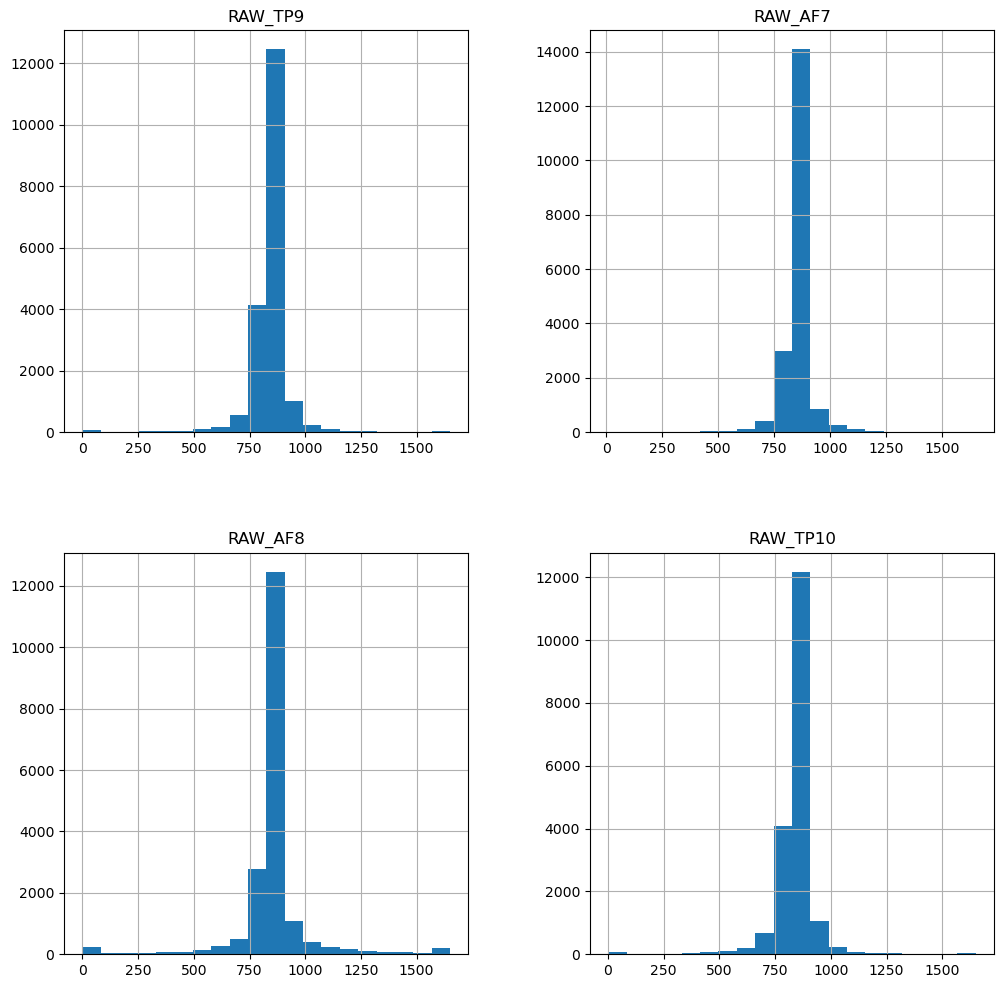

In [389]:
numerical_data.hist(figsize=(12,12),bins=20)
plt.show()

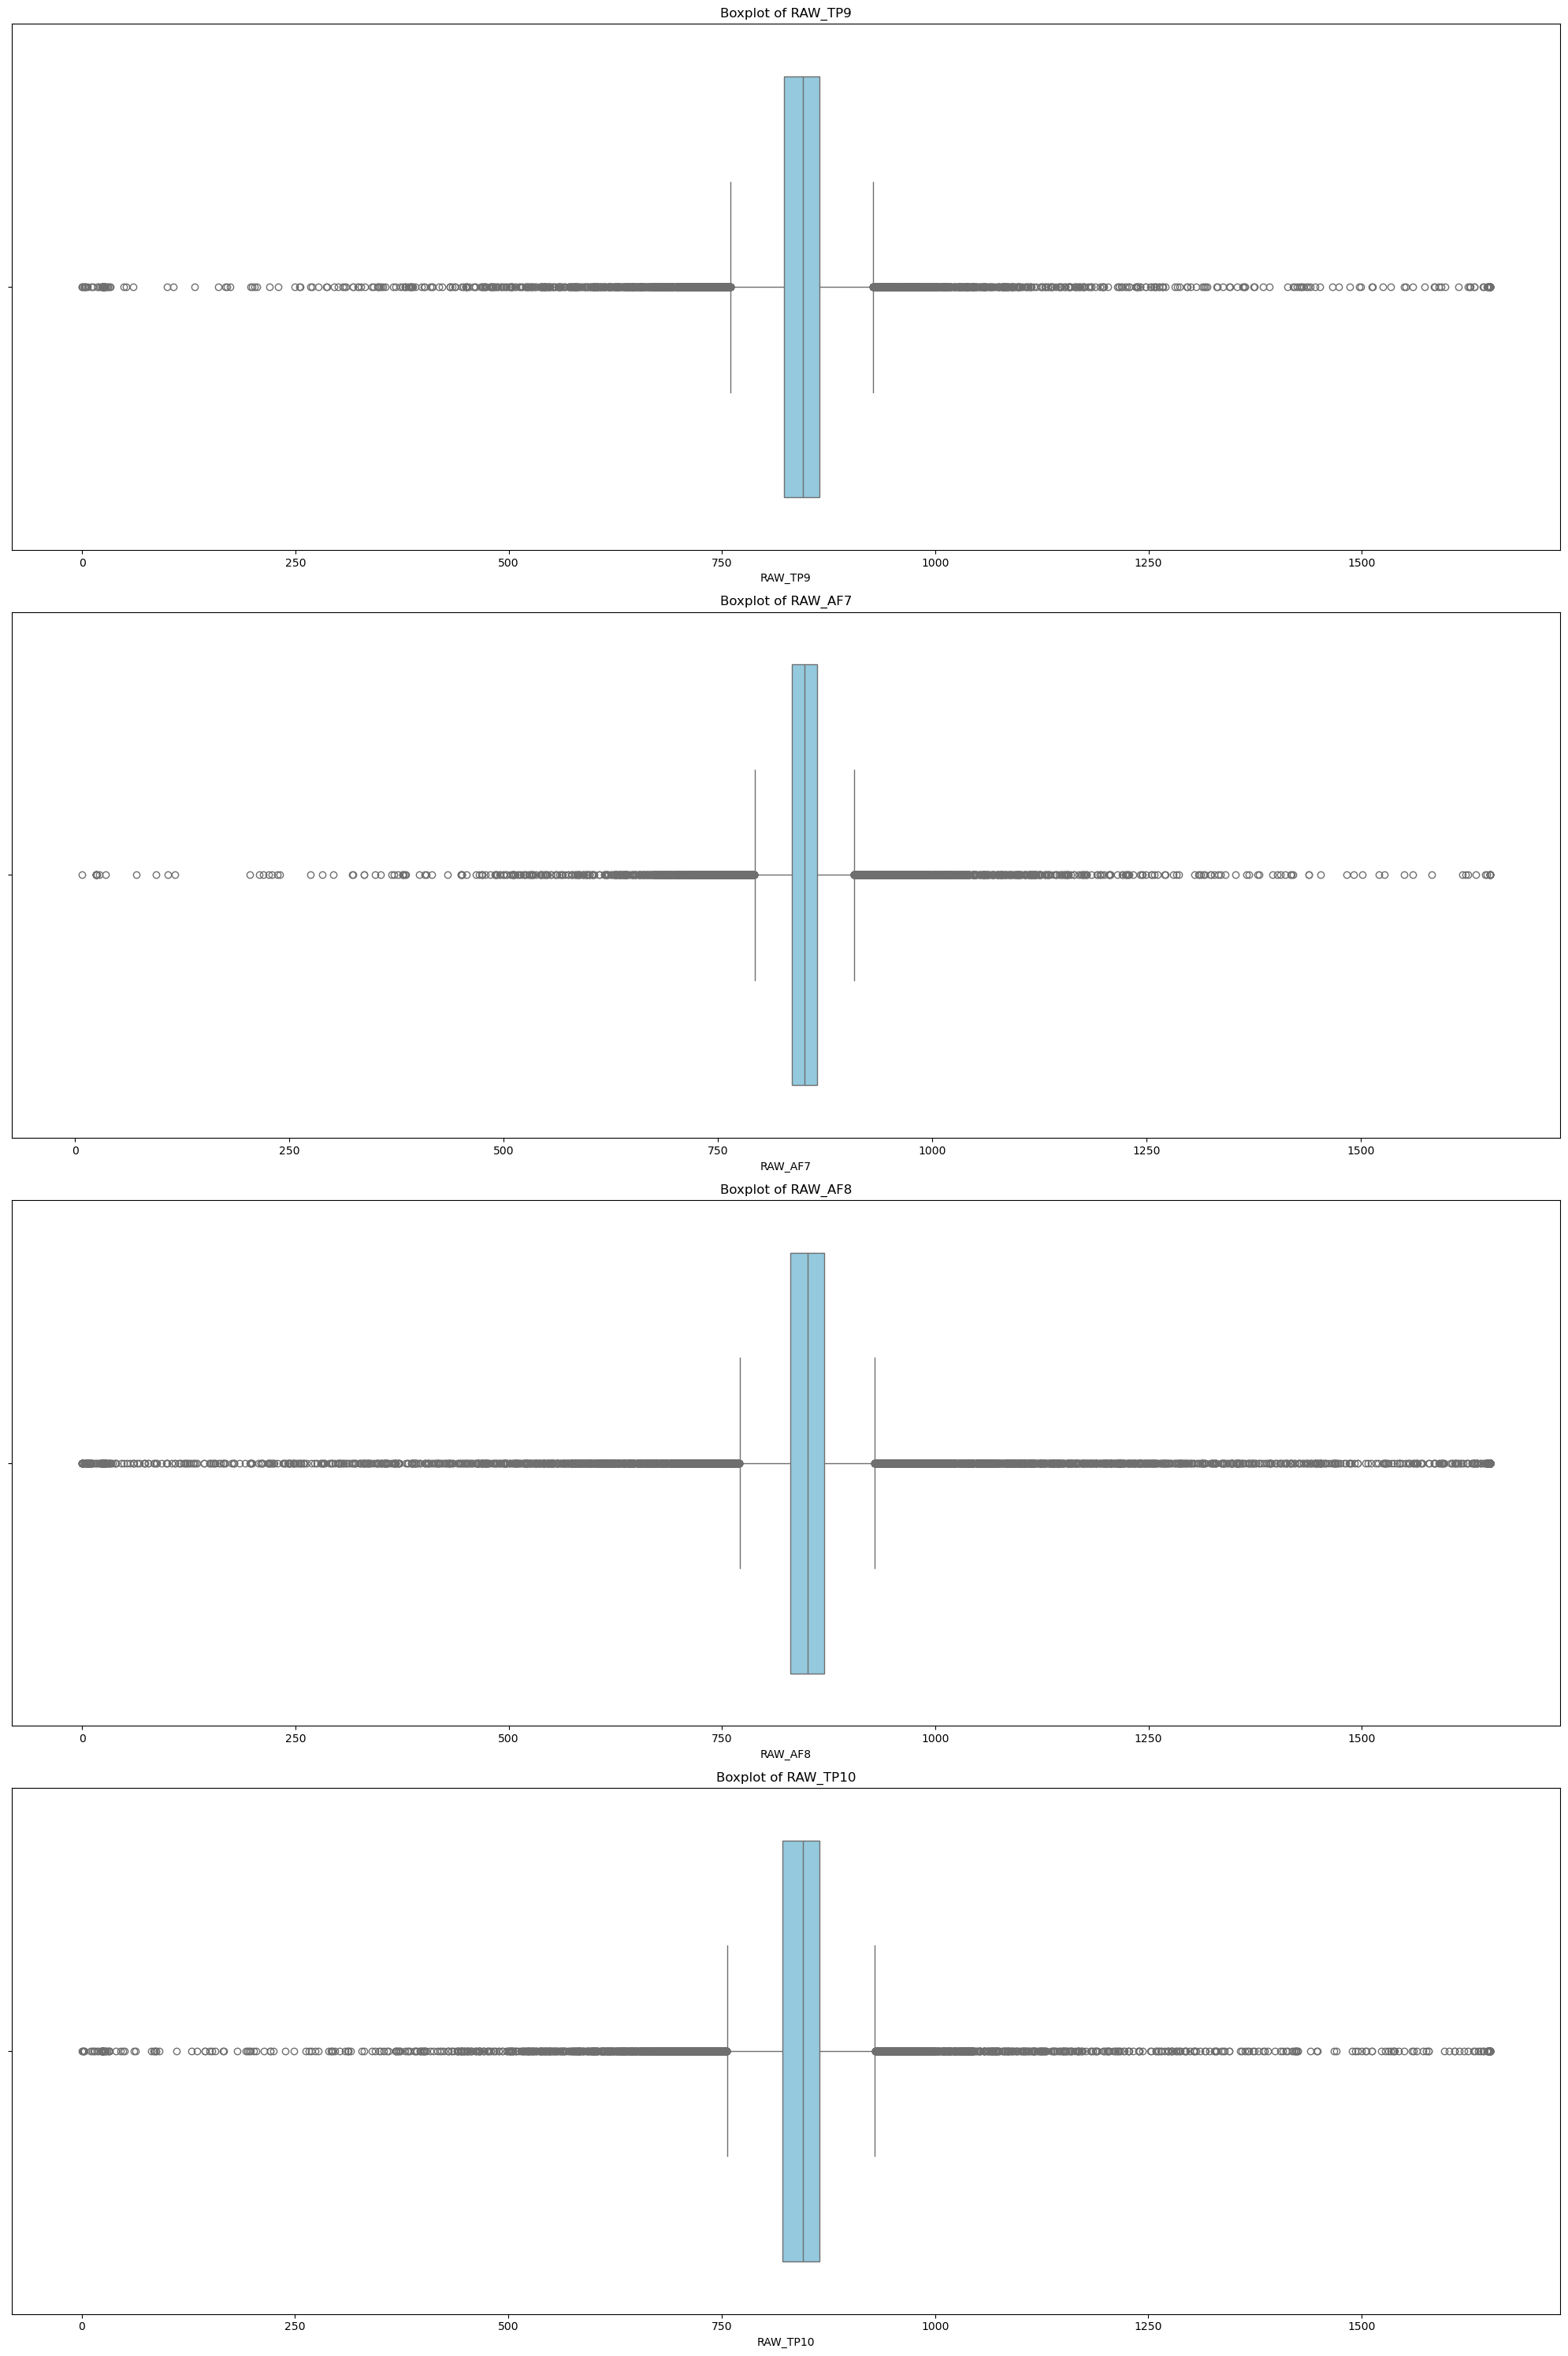

In [390]:
# Select only numerical columns for boxplot analysis
numeric_cols = csvfile.select_dtypes(include=['int64', 'float64']).columns

# Set up the figure
plt.figure(figsize=(20, 30))

# Plot boxplots for each numerical feature including the target variable 'OUTCOME'
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.boxplot(x=csvfile[col], color='skyblue')
    plt.title(f'Boxplot of {col}', fontsize=12)
    plt.tight_layout()

plt.show()

In [391]:
numerical_data.nunique()

RAW_TP9     1431
RAW_AF7     1264
RAW_AF8     2068
RAW_TP10    1551
dtype: int64

In [392]:
# Checking null values
csvfile.isnull().sum()

Participant       0
Classification    0
RAW_TP9           0
RAW_AF7           0
RAW_AF8           0
RAW_TP10          0
dtype: int64

In [393]:
# unique values counts
unique_counts=categorical_data.nunique()
print(unique_counts)

Participant       31
Classification     4
dtype: int64


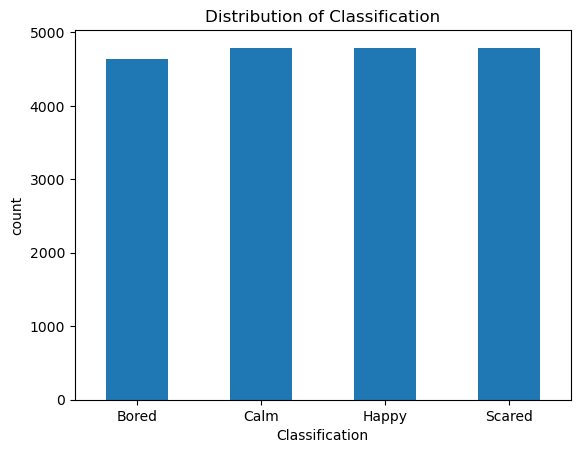

In [394]:
for col in categorical_features:
    if col!='Participant':
        plt.title(f'Distribution of {col}')
        categorical_data[col].value_counts().sort_index().plot(kind='bar', rot=0, xlabel=col,ylabel='count')
        plt.show()

In [395]:
# Calculate the correlation matrix
correlation_matrix = numerical_data.corr()
correlation_matrix


,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10
RAW_TP9,1.000000,0.118787,0.011482,0.478805
RAW_AF7,0.118787,1.000000,0.122848,0.094735
RAW_AF8,0.011482,0.122848,1.000000,0.001692
RAW_TP10,0.478805,0.094735,0.001692,1.000000


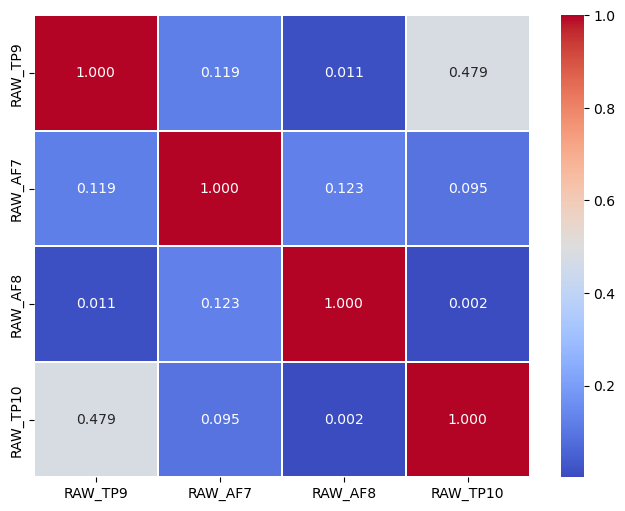

In [396]:
# Plotting the heatmap for correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.3f', linewidths=0.3)
plt.show()

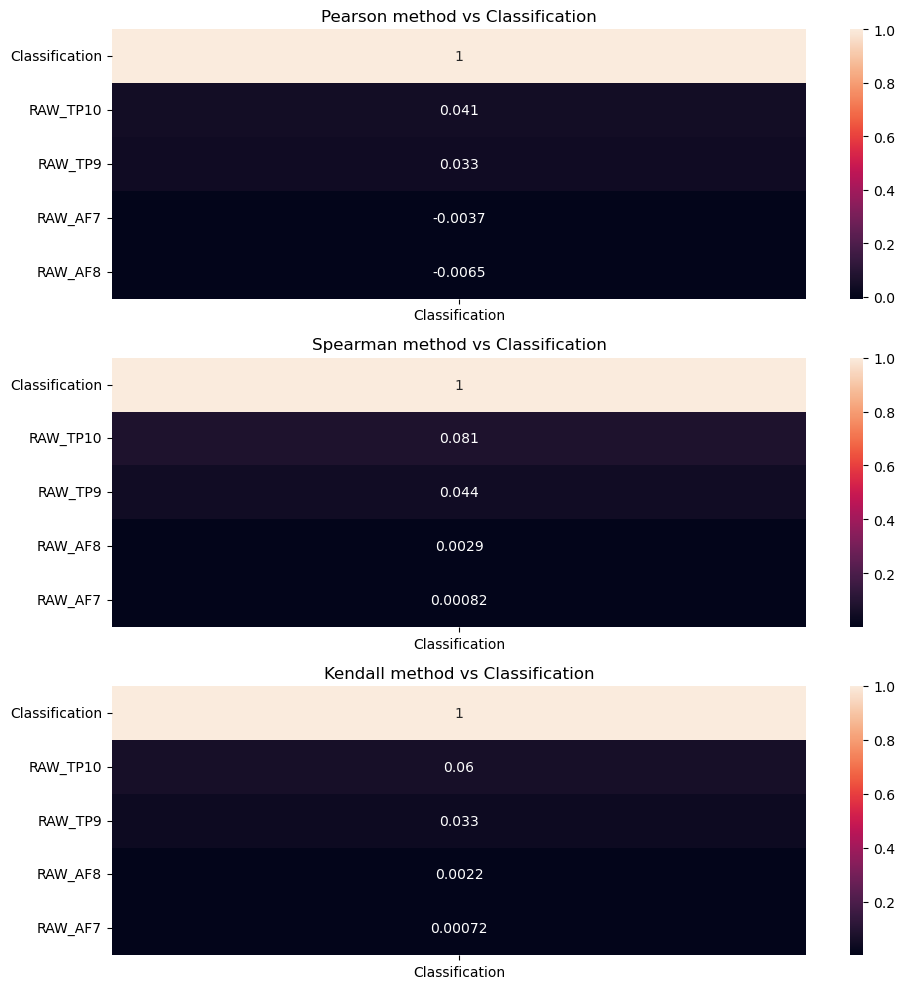

In [397]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
## Correlation coefficient using different methods

# Pick a target column that actually exists at this point in the notebook
target_candidates = ['Classification', 'stroke']
target_col = next((c for c in target_candidates if c in csvfile.columns), None)
if target_col is None:
    raise KeyError(f"None of the target columns {target_candidates} exist in csvfile. Available columns: {list(csvfile.columns)}")

# Build a numeric-only dataframe for correlation, and ensure the target is numeric too
corr_df = csvfile.select_dtypes(include='number').copy()
target_numeric_col = target_col
if target_col not in corr_df.columns:
    # Target is not numeric yet; convert to numeric codes just for correlation purposes
    corr_df[target_col] = pd.factorize(csvfile[target_col])[0]

def corr_with_target(method: str) -> pd.DataFrame:
    corr_mat = corr_df.corr(method=method)
    return corr_mat[[target_numeric_col]].sort_values(by=target_numeric_col, ascending=False)

corr1 = corr_with_target('pearson')
corr2 = corr_with_target('spearman')
corr3 = corr_with_target('kendall')

# setting titles for each plot
ax[0].set_title(f'Pearson method vs {target_col}')
ax[1].set_title(f'Spearman method vs {target_col}')
ax[2].set_title(f'Kendall method vs {target_col}')

## Generating heatmaps of each method
sns.heatmap(corr1, ax=ax[0], annot=True)
sns.heatmap(corr2, ax=ax[1], annot=True)
sns.heatmap(corr3, ax=ax[2], annot=True)

plt.tight_layout()
plt.show()

In [398]:
# Check Imbalance in data

# Pick a target column that actually exists at this point in the notebook
target_candidates = ['Classification', 'stroke']
target_col = next((c for c in target_candidates if c in csvfile.columns), None)
if target_col is None:
    raise KeyError(f"None of the target columns {target_candidates} exist in csvfile. Available columns: {list(csvfile.columns)}")

# Count instances per class (works for numeric or string labels)
class_counts = csvfile[target_col].value_counts(dropna=False).sort_index()

imbalance_df = (
    class_counts
    .rename('count')
    .to_frame()
    .assign(percentage=lambda d: (d['count'] / d['count'].sum()) * 100)
    .reset_index()
    .rename(columns={'index': target_col})
)

imbalance_df

,Classification,count,percentage
0,Bored,4644,24.431818
1,Calm,4787,25.184133
2,Happy,4791,25.205177
3,Scared,4786,25.178872


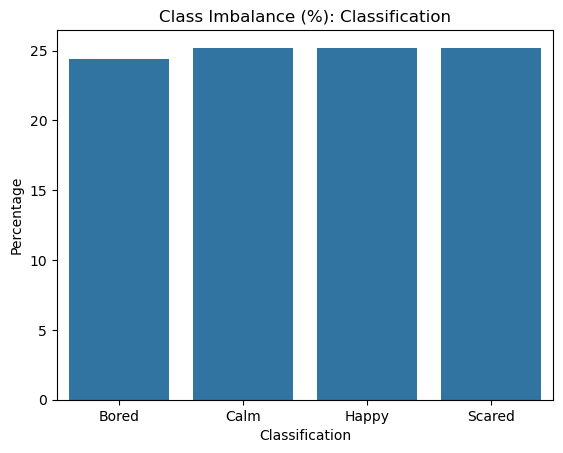

In [399]:
# Plot imbalance percentages
target_candidates = ['Classification', 'stroke']
target_col = next((c for c in target_candidates if c in csvfile.columns), None)
if target_col is None:
    raise KeyError(f"None of the target columns {target_candidates} exist in csvfile. Available columns: {list(csvfile.columns)}")

sns.barplot(data=imbalance_df, x=target_col, y='percentage')
plt.title(f'Class Imbalance (%): {target_col}')
plt.xlabel(target_col)
plt.ylabel('Percentage')
plt.show()

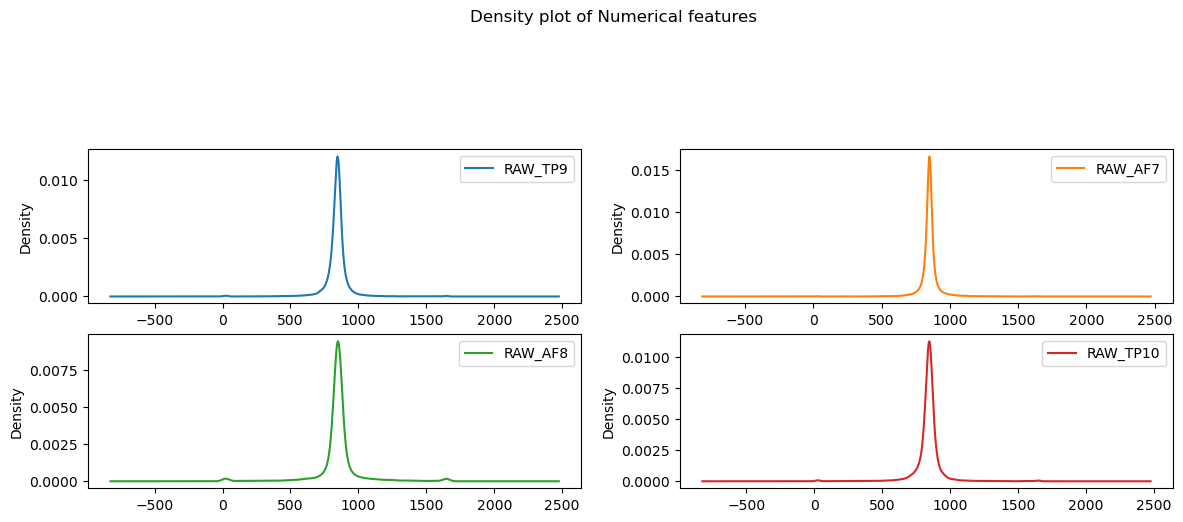

In [400]:
numerical_data.plot(kind='density',figsize=(14,14),subplots=True,layout=(6,2),title="Density plot of Numerical features",sharex=False)
plt.show()

In [401]:
# Checking null values
csvfile.isnull().sum()

Participant       0
Classification    0
RAW_TP9           0
RAW_AF7           0
RAW_AF8           0
RAW_TP10          0
dtype: int64

In [402]:
# # Encoding to numbers
csvfile['Classification'] = csvfile['Classification'].map({'Bored':3,'Happy':2,'Scared':1,'Calm':0})

In [403]:
csvfile.head(10)

,Participant,Classification,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10
0,p1,0,848.1685,838.49817,861.86810,865.49450
1,p1,0,840.5128,851.79486,847.36260,844.94507
2,p1,0,819.9634,823.18680,815.53110,833.26010
3,p1,0,838.0952,842.12450,848.97437,850.58606
4,p1,0,849.7802,849.78020,829.63370,838.49817
5,p1,0,834.0659,847.76556,839.30400,844.94507
6,p1,0,808.2784,864.68866,877.58240,867.50916
7,p1,0,813.1135,848.97437,865.49450,836.88650
8,p1,0,823.5897,826.81320,888.86444,884.43225
9,p1,0,801.8315,874.76190,864.28570,826.00730


In [404]:
# X = Input features, Y = Output label
# Keep Participant separately (useful for windowing later), but do NOT include it in model features.
participant_series = csvfile['Participant'] if 'Participant' in csvfile.columns else None

feature_cols = [c for c in csvfile.columns if c not in ['Classification', 'Participant']]
x = csvfile[feature_cols]
y = csvfile['Classification']

print('Feature columns used for ML:', feature_cols)
if participant_series is not None:
    print('Participant column retained separately for windowing/grouping.')

Feature columns used for ML: ['RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10']
Participant column retained separately for windowing/grouping.


In [405]:
# --- Windowed EEG feature extraction (PSD bandpower) ---
# This replaces the ineffective "single-row raw voltage" learning signal with windowed frequency-band features.

eeg_cols = ['RAW_TP9','RAW_AF7','RAW_AF8','RAW_TP10']
missing = [c for c in eeg_cols if c not in csvfile.columns]
if missing:
    raise KeyError(f"Missing EEG columns: {missing}. Available: {list(csvfile.columns)}")

# IMPORTANT: Your CSV has no explicit timestamp/sample-rate column.
# So we window in *samples* rather than seconds. If you know the sampling rate, keep fs_hz accurate for Welch frequencies.
fs_hz = 256  # used only for frequency axis of Welch
window_samples = 64   # produces multiple windows per segment (~154 rows each)
step_samples = 16
win = int(window_samples)
step = int(step_samples)
if win <= 16 or step <= 0:
    raise ValueError('Invalid window/step; choose window_samples > 16 and positive step_samples.')

bands = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta' : (13, 30),
    'gamma': (30, 45),
}

def bandpower_welch(x_1d: np.ndarray, fs: int, fmin: float, fmax: float) -> float:
    # Welch PSD then integrate in-band power.
    # With short windows (e.g., 64 samples), use nfft=256 to keep ~1 Hz bins so delta/theta bands are representable.
    nperseg = min(256, int(x_1d.shape[0]))
    if nperseg < 16:
        return 0.0
    nfft = 256
    f, pxx = welch(
        x_1d, fs=fs, nperseg=nperseg, noverlap=nperseg // 2, nfft=nfft
    )
    mask = (f >= fmin) & (f < fmax)
    if not np.any(mask):
        return 0.0
    return float(np.trapz(pxx[mask], f[mask]))

# Ensure labels are numeric 0..K-1
if not np.issubdtype(csvfile['Classification'].dtype, np.number):
    csvfile['Classification'] = pd.factorize(csvfile['Classification'])[0]

# Create windows within each Participant+Classification segment to avoid mixed-label windows
group_cols = ['Classification']
if 'Participant' in csvfile.columns:
    group_cols = ['Participant', 'Classification']

# Participant-wise normalization helps subject-independent generalization (reduces per-subject offsets)
participant_stats = None
if 'Participant' in csvfile.columns:
    stats = {}
    for pid, gpid in csvfile.groupby('Participant', sort=False):
        m = gpid[eeg_cols].to_numpy(dtype=np.float32).mean(axis=0, keepdims=True)
        s = gpid[eeg_cols].to_numpy(dtype=np.float32).std(axis=0, keepdims=True) + 1e-6
        stats[pid] = (m, s)
    participant_stats = stats

feature_rows = []
y_band = []
groups_win = []
seq_windows = []

# Diagnostics: how long are the segments?
seg_lengths = []
for _, g in csvfile.groupby(group_cols, sort=False):
    seg_lengths.append(len(g))
print('Segment length summary (rows per Participant×Class):')
print(pd.Series(seg_lengths).describe())
print('Using win=', win, 'step=', step)

for key, g in csvfile.groupby(group_cols, sort=False):
    # key is (participant, class) or (class,)
    if isinstance(key, tuple):
        participant_id = key[0] if ('Participant' in group_cols) else None
        class_id = key[-1]
    else:
        participant_id = None
        class_id = key
    eeg = g[eeg_cols].to_numpy(dtype=np.float32)
    # Normalize per participant (if available)
    if participant_id is not None and participant_stats is not None and participant_id in participant_stats:
        m, s = participant_stats[participant_id]
        eeg = (eeg - m) / s
    n = eeg.shape[0]
    if n < win:
        continue
    for start in range(0, n - win + 1, step):
        seg = eeg[start:start+win]  # (win, 4)
        if not np.isfinite(seg).all():
            continue
        # PSD bandpower features: 5 bands x 4 channels = 20 features
        feats = {}
        for ch_name in eeg_cols:
            xch = seg[:, eeg_cols.index(ch_name)]
            for bname, (fmin, fmax) in bands.items():
                bp = bandpower_welch(xch, fs_hz, fmin, fmax)
                feats[f"{ch_name}_{bname}"] = np.log10(bp + 1e-12)
        feature_rows.append(feats)
        y_band.append(int(class_id))
        if participant_id is not None:
            groups_win.append(participant_id)
        seq_windows.append(seg)

if len(seq_windows) == 0:
    raise ValueError(
        'Built 0 windows. Increase data per segment or reduce window_samples. '
        f'Currently win={win}, step={step}. Try window_samples=32, step_samples=8.'
    )

x_band = pd.DataFrame(feature_rows)
X_seq_all = np.stack(seq_windows, axis=0).astype(np.float32)
y_band = np.asarray(y_band, dtype=np.int32)
if len(groups_win) > 0:
    groups_win = np.asarray(groups_win)

print('Built windowed dataset:')
print('x_band:', x_band.shape, 'X_seq_all:', X_seq_all.shape, 'y_band:', y_band.shape)
print('Class counts:', pd.Series(y_band).value_counts().sort_index().to_dict())

# Sanity checks
if x_band.isna().any().any():
    raise ValueError('NaNs found in bandpower features; check window_samples/fs_hz and raw data.')
if X_seq_all.shape[0] != x_band.shape[0] or X_seq_all.shape[0] != y_band.shape[0]:
    raise RuntimeError('Window feature alignment mismatch.')

Segment length summary (rows per Participant×Class):
count    124.000000
mean     153.290323
std        3.848290
min      125.000000
25%      154.000000
50%      154.000000
75%      155.000000
max      158.000000
dtype: float64
Using win= 64 step= 16
Built windowed dataset:
x_band: (740, 20) X_seq_all: (740, 64, 4) y_band: (740,)
Class counts: {0: 186, 1: 186, 2: 186, 3: 182}


In [406]:
numerical_data = csvfile.select_dtypes(include='number')
numerical_features=numerical_data.columns.tolist()
numerical_data.var()

Classification        1.242260
RAW_TP9            9091.708289
RAW_AF7            5428.273991
RAW_AF8           29189.988093
RAW_TP10          11500.888565
dtype: float64

In [407]:
# Feature engineering on windowed data (improves signal vs raw log-bandpowers)
# Builds additional features from x_band (bandpower) and X_seq_all (time-domain stats).
if 'x_band' not in globals() or 'X_seq_all' not in globals():
    raise NameError('Run the windowed PSD feature extraction cell first (defines x_band and X_seq_all).')

x_feat = x_band.copy()
eps = 1e-12

# ---- Relative bandpowers + ratios (computed in linear domain) ----
# Convert log10(bp + eps) back to approx linear bp for ratios
for ch in ['RAW_TP9','RAW_AF7','RAW_AF8','RAW_TP10']:
    band_cols = [f"{ch}_{b}" for b in ['delta','theta','alpha','beta','gamma'] if f"{ch}_{b}" in x_feat.columns]
    if len(band_cols) != 5:
        continue
    bp_lin = np.stack([(10 ** x_feat[c].to_numpy(dtype=np.float64) - eps) for c in band_cols], axis=1)
    bp_lin = np.clip(bp_lin, 0.0, None)
    total = bp_lin.sum(axis=1, keepdims=True) + eps
    rel = bp_lin / total
    for i, b in enumerate(['delta','theta','alpha','beta','gamma']):
        x_feat[f"{ch}_{b}_rel"] = rel[:, i].astype(np.float32)
        x_feat[f"{ch}_{b}_logrel"] = np.log10(rel[:, i] + eps).astype(np.float32)
    # A few common ratios (log-ratio is often more stable)
    def _col(bname: str) -> np.ndarray:
        return bp_lin[:, ['delta','theta','alpha','beta','gamma'].index(bname)]
    alpha = _col('alpha'); beta = _col('beta'); theta = _col('theta'); delta = _col('delta')
    x_feat[f"{ch}_alpha_beta"] = (alpha + eps) / (beta + eps)
    x_feat[f"{ch}_theta_beta"] = (theta + eps) / (beta + eps)
    x_feat[f"{ch}_abd_ttd"] = (alpha + beta + eps) / (theta + delta + eps)
    x_feat[f"{ch}_log_alpha_beta"] = np.log10((alpha + eps) / (beta + eps))
    x_feat[f"{ch}_log_theta_beta"] = np.log10((theta + eps) / (beta + eps))
    x_feat[f"{ch}_log_abd_ttd"] = np.log10((alpha + beta + eps) / (theta + delta + eps))

# ---- Simple time-domain stats from raw window sequences ----
# X_seq_all: (n_windows, timesteps, 4) aligned with x_band rows
Xw = np.asarray(X_seq_all, dtype=np.float32)
if Xw.ndim != 3 or Xw.shape[0] != len(x_feat) or Xw.shape[2] != 4:
    raise ValueError(f"Unexpected X_seq_all shape {Xw.shape}; expected (n_windows, timesteps, 4) aligned with x_band.")

ch_names = ['RAW_TP9','RAW_AF7','RAW_AF8','RAW_TP10']
means = Xw.mean(axis=1)
stds = Xw.std(axis=1)
ptp = Xw.max(axis=1) - Xw.min(axis=1)
rms = np.sqrt(np.mean(np.square(Xw), axis=1))
absmean = np.mean(np.abs(Xw), axis=1)
for i, ch in enumerate(ch_names):
    x_feat[f"{ch}_td_mean"] = means[:, i]
    x_feat[f"{ch}_td_std"] = stds[:, i]
    x_feat[f"{ch}_td_ptp"] = ptp[:, i]
    x_feat[f"{ch}_td_rms"] = rms[:, i]
    x_feat[f"{ch}_td_absmean"] = absmean[:, i]

# ---- Asymmetry features (AF7 vs AF8) ----
# Use log-bandpowers when present (stable differences)
for b in ['delta','theta','alpha','beta','gamma']:
    c1 = f"RAW_AF7_{b}"
    c2 = f"RAW_AF8_{b}"
    if c1 in x_feat.columns and c2 in x_feat.columns:
        x_feat[f"AF7_minus_AF8_{b}"] = (x_feat[c1] - x_feat[c2]).astype(np.float32)
        x_feat[f"AF7_over_AF8_{b}"] = (10 ** x_feat[c1] + eps) / (10 ** x_feat[c2] + eps)
        x_feat[f"log_AF7_over_AF8_{b}"] = np.log10(x_feat[f"AF7_over_AF8_{b}"] + eps).astype(np.float32)

# Overwrite x_band so downstream split/scaling uses enhanced features
x_band = x_feat
print('Enhanced x_band features:', x_band.shape)
print('Example columns:', list(x_band.columns[:10]))

Enhanced x_band features: (740, 119)
Example columns: ['RAW_TP9_delta', 'RAW_TP9_theta', 'RAW_TP9_alpha', 'RAW_TP9_beta', 'RAW_TP9_gamma', 'RAW_AF7_delta', 'RAW_AF7_theta', 'RAW_AF7_alpha', 'RAW_AF7_beta', 'RAW_AF7_gamma']


In [408]:
# Train/Test Split
# If windowed features exist, split windows (and keep raw window sequences aligned).
if 'x_band' in globals() and 'y_band' in globals() and 'X_seq_all' in globals():
    # Local import so this cell works even if the import cell wasn't re-run
    from sklearn.model_selection import GroupShuffleSplit
    
    idx = np.arange(len(x_band))
    y_arr = np.asarray(y_band, dtype=np.int32)

    if 'groups_win' in globals() and ('Participant' in csvfile.columns) and len(np.asarray(groups_win)) == len(idx):
        splitter = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=5)
        train_idx, test_idx = next(splitter.split(idx, y_arr, groups=np.asarray(groups_win)))
    else:
        train_idx, test_idx = train_test_split(idx, test_size=0.3, random_state=5, stratify=y_arr)

    X_train = x_band.iloc[train_idx].reset_index(drop=True)
    X_test = x_band.iloc[test_idx].reset_index(drop=True)
    y_train = pd.Series(y_arr[train_idx])
    y_test = pd.Series(y_arr[test_idx])

    # Correct sequence shape: (n_windows, timesteps, n_channels=4)
    X_train_seq = X_seq_all[train_idx]
    X_test_seq = X_seq_all[test_idx]

    print('Using windowed PSD features + raw sequences')
    print('X_train:', X_train.shape, 'y_train:', y_train.shape)
    print('X_test :', X_test.shape, 'y_test :', y_test.shape)
    print('X_train_seq:', X_train_seq.shape, 'X_test_seq:', X_test_seq.shape)
else:
    # Fallback: row-wise split on raw features (not recommended for EEG emotion classification)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=5, stratify=y)
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)

Using windowed PSD features + raw sequences
X_train: (504, 119) y_train: (504,)
X_test : (236, 119) y_test : (236,)
X_train_seq: (504, 64, 4) X_test_seq: (236, 64, 4)


In [409]:
# Robust Scaling
scaler = RobustScaler()

In [410]:
# Scaling train and test inputs
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [411]:
# Quick diagnostic: subject-independent (group) split vs random split
if 'x_band' not in globals() or 'y_band' not in globals():
    raise NameError('Run the windowing + feature-engineering cells first (need x_band and y_band).')
if 'groups_win' not in globals():
    raise NameError('groups_win not found; need Participant-based groups to run this diagnostic.')

from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X = x_band.to_numpy(dtype=np.float32)
y = np.asarray(y_band, dtype=np.int32)
groups = np.asarray(groups_win)
idx = np.arange(len(y))

def fit_eval(train_idx, test_idx, name: str):
    scaler = RobustScaler()
    Xtr = scaler.fit_transform(X[train_idx])
    Xte = scaler.transform(X[test_idx])
    ytr, yte = y[train_idx], y[test_idx]

    models = {
        'LinearSVC': LinearSVC(class_weight='balanced', random_state=5, dual=False, max_iter=10000),
        'RandomForest': RandomForestClassifier(n_estimators=400, class_weight='balanced', random_state=5),
    }
    out = {}
    for mname, m in models.items():
        m.fit(Xtr, ytr)
        pred = m.predict(Xte)
        out[mname] = float(accuracy_score(yte, pred))
    print(name, out)
    return out

# Group-based split (harder, no participant leakage)
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=5)
g_train, g_test = next(gss.split(idx, y, groups=groups))
fit_eval(g_train, g_test, 'GroupSplit (no subject leakage)')

# Random stratified split (easier, can leak participant-specific patterns)
r_train, r_test = train_test_split(idx, test_size=0.3, random_state=5, stratify=y)
fit_eval(r_train, r_test, 'RandomSplit (possible leakage)')

GroupSplit (no subject leakage) {'LinearSVC': 0.3389830508474576, 'RandomForest': 0.3516949152542373}
RandomSplit (possible leakage) {'LinearSVC': 0.40540540540540543, 'RandomForest': 0.527027027027027}


{'LinearSVC': 0.40540540540540543, 'RandomForest': 0.527027027027027}

In [412]:
# Auto-tune for higher accuracy (honest vs leaky)
# - Honest: participant-disjoint split + GroupKFold CV (no subject leakage)
# - Leaky ceiling: random split + include Participant as a feature (will inflate accuracy)

import numpy as np
import pandas as pd

from sklearn.model_selection import GroupShuffleSplit, GroupKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.svm import LinearSVC

if 'x_band' not in globals() or 'y_band' not in globals() or 'groups_win' not in globals():
    raise NameError('Need x_band, y_band, groups_win. Run windowing + feature engineering first.')

X_df = x_band.copy()
y_arr = np.asarray(y_band, dtype=np.int32)
groups = np.asarray(groups_win)

# -------------------- Honest evaluation (GroupSplit holdout + GroupKFold tuning) --------------------
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=5)
idx = np.arange(len(y_arr))
train_idx, test_idx = next(gss.split(idx, y_arr, groups=groups))

X_train_df = X_df.iloc[train_idx].reset_index(drop=True)
y_train_arr = y_arr[train_idx]
g_train = groups[train_idx]
X_test_df = X_df.iloc[test_idx].reset_index(drop=True)
y_test_arr = y_arr[test_idx]

# Models to try (keep it fast)
candidates = []

# LinearSVC (scaled)
svc_pipe = Pipeline([
    ('scale', RobustScaler()),
    ('clf', LinearSVC(class_weight='balanced', dual=False, random_state=5, max_iter=20000)),
])
svc_params = {
    'clf__C': np.logspace(-2, 2, 15),
}
candidates.append(('LinearSVC', svc_pipe, svc_params))

# RandomForest
rf = RandomForestClassifier(class_weight='balanced', random_state=5, n_jobs=-1)
rf_params = {
    'n_estimators': [300, 600, 1000],
    'max_depth': [None, 8, 12, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 0.3, 0.5, 0.8],
}
candidates.append(('RandomForest', rf, rf_params))

# ExtraTrees (often better on engineered tabular features)
et = ExtraTreesClassifier(class_weight='balanced', random_state=5, n_jobs=-1)
et_params = {
    'n_estimators': [500, 1000, 1500],
    'max_depth': [None, 8, 12, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 0.3, 0.5, 0.8],
}
candidates.append(('ExtraTrees', et, et_params))

# HistGradientBoosting (fast, strong baseline)
hgb = HistGradientBoostingClassifier(random_state=5)
hgb_params = {
    'learning_rate': [0.03, 0.06, 0.1],
    'max_depth': [3, 5, 7, None],
    'max_leaf_nodes': [15, 31, 63],
    'min_samples_leaf': [10, 20, 40],
}
candidates.append(('HistGB', hgb, hgb_params))

cv = GroupKFold(n_splits=5)
best_honest = None
honest_results = {}

for name, model, params in candidates:
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        n_iter=12,
        scoring='accuracy',
        cv=cv.split(X_train_df, y_train_arr, groups=g_train),
        random_state=5,
        n_jobs=-1,
        verbose=0,
    )
    search.fit(X_train_df, y_train_arr)
    best = search.best_estimator_
    pred = best.predict(X_test_df)
    acc = float(accuracy_score(y_test_arr, pred))
    honest_results[name] = {'cv_best': float(search.best_score_), 'test_acc': acc, 'best_params': search.best_params_}
    if best_honest is None or acc > best_honest[1]:
        best_honest = (name, acc)

print('HONEST (GroupSplit holdout) results:')
for k, v in sorted(honest_results.items(), key=lambda kv: kv[1]['test_acc'], reverse=True):
    print(f"  {k:12s} test_acc={v['test_acc']:.3f}  cv_best={v['cv_best']:.3f}")
print('Best honest model:', best_honest)

# -------------------- Leaky ceiling (Random split + include Participant) --------------------
# This will boost accuracy but is not valid for subject-independent claims.
X_leak = X_df.copy()
X_leak['Participant'] = groups  # window-level participant id
cat_cols = ['Participant']
num_cols = [c for c in X_leak.columns if c not in cat_cols]

pre = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ],
    remainder='drop',
)

X_tr, X_te, y_tr, y_te = train_test_split(X_leak, y_arr, test_size=0.3, random_state=5, stratify=y_arr)

leaky_models = {
    'ExtraTrees+PID': ExtraTreesClassifier(n_estimators=1500, random_state=5, n_jobs=-1),
    'RandomForest+PID': RandomForestClassifier(n_estimators=1000, random_state=5, n_jobs=-1),
    'LinearSVC+PID': LinearSVC(dual=False, random_state=5, max_iter=20000),
}

print('\nLEAKY (RandomSplit + Participant feature) results:')
for name, base in leaky_models.items():
    pipe = Pipeline([('pre', pre), ('clf', base)])
    pipe.fit(X_tr, y_tr)
    pred = pipe.predict(X_te)
    acc = float(accuracy_score(y_te, pred))
    print(f"  {name:16s} acc={acc:.3f}")

HONEST (GroupSplit holdout) results:
  ExtraTrees   test_acc=0.403  cv_best=0.352
  RandomForest test_acc=0.377  cv_best=0.347
  LinearSVC    test_acc=0.343  cv_best=0.298
  HistGB       test_acc=0.326  cv_best=0.323
Best honest model: ('ExtraTrees', 0.4025423728813559)

LEAKY (RandomSplit + Participant feature) results:
  ExtraTrees+PID   acc=0.667
  RandomForest+PID acc=0.554
  LinearSVC+PID    acc=0.387


In [413]:
print("per-feature minimum before scaling:\n {}".format(X_train.min(axis=0)))
print("per-feature maximum before scaling:\n {}".format(X_train.max(axis=0)))

per-feature minimum before scaling:
 RAW_TP9_delta            -4.617938
RAW_TP9_theta            -4.171038
RAW_TP9_alpha            -3.790615
RAW_TP9_beta             -2.486448
RAW_TP9_gamma            -2.757740
                            ...   
AF7_over_AF8_beta         0.009800
log_AF7_over_AF8_beta    -2.008782
AF7_minus_AF8_gamma      -2.464707
AF7_over_AF8_gamma        0.003430
log_AF7_over_AF8_gamma   -2.464707
Length: 119, dtype: float64
per-feature maximum before scaling:
 RAW_TP9_delta              -0.695480
RAW_TP9_theta              -0.342497
RAW_TP9_alpha              -0.148978
RAW_TP9_beta                0.384710
RAW_TP9_gamma               0.225194
                             ...    
AF7_over_AF8_beta         153.473271
log_AF7_over_AF8_beta       2.186033
AF7_minus_AF8_gamma         1.919362
AF7_over_AF8_gamma         83.054268
log_AF7_over_AF8_gamma      1.919362
Length: 119, dtype: float64


In [414]:
print("per-feature minimum after scaling:\n {}".format(X_train_scaled.min(axis=0)))
print("per-feature maximum after scaling:\n {}".format(X_train_scaled.max(axis=0)))

per-feature minimum after scaling:
 [-2.41349105 -2.25807902 -2.2495562  -1.88643636 -1.97988463 -3.17202091
 -2.81529947 -3.36267329 -2.60883877 -2.7342766  -2.46019739 -2.61782124
 -2.30559351 -2.81356551 -2.37017239 -3.83755312 -3.48634595 -3.26373633
 -2.98410802 -3.44374969 -0.52524405 -3.54197766 -0.67095104 -3.15262521
 -0.73959995 -3.3016583  -1.70624233 -3.95222631 -1.15823828 -2.97464104
 -0.58542441 -0.48791822 -0.48484093 -2.64776901 -2.66435234 -1.88383645
 -0.53261988 -2.85792676 -0.76276993 -3.73087807 -0.93990147 -3.94258261
 -1.99592149 -4.67870962 -1.45612042 -4.221652   -0.77901719 -0.60954779
 -0.60466445 -3.39325761 -3.3221359  -2.12142747 -0.61530892 -3.34627022
 -0.74664807 -2.73566279 -0.89506004 -3.90289392 -1.65225228 -3.68183698
 -1.32502131 -3.53098989 -0.71728971 -0.63182526 -0.56444624 -3.30083708
 -2.61012136 -1.87894076 -0.55782385 -2.86690857 -0.7108133  -2.29270938
 -0.76004724 -3.20668266 -1.6274834  -4.03572613 -1.25674064 -4.00937207
 -0.72029353 -0

In [415]:
csvfile.head(5)

,Participant,Classification,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10
0,p1,0,848.1685,838.49817,861.86810,865.49450
1,p1,0,840.5128,851.79486,847.36260,844.94507
2,p1,0,819.9634,823.18680,815.53110,833.26010
3,p1,0,838.0952,842.12450,848.97437,850.58606
4,p1,0,849.7802,849.78020,829.63370,838.49817


/usr/lib/python3/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3/dist-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


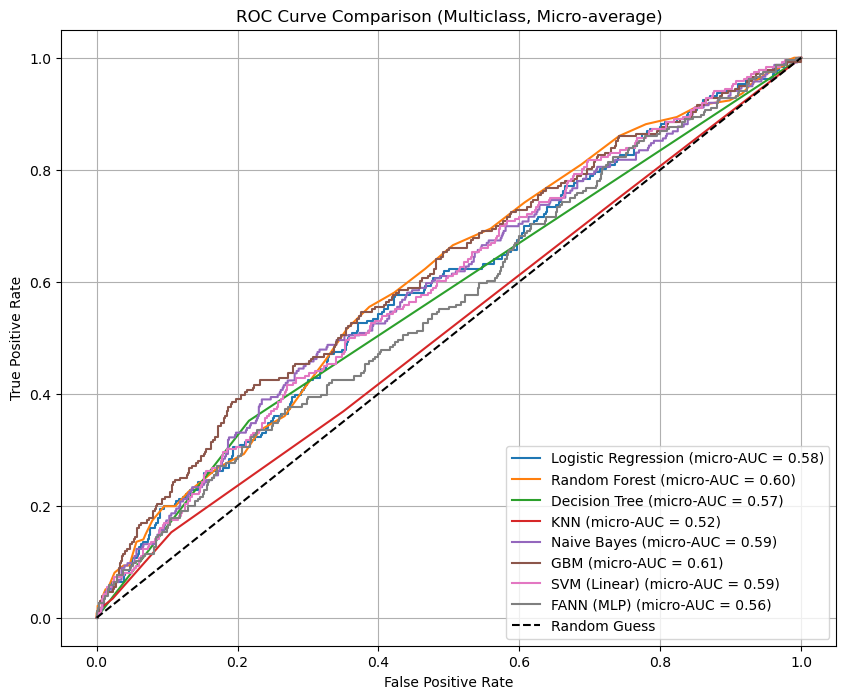

In [416]:
# Determining which model to use (multiclass ROC: micro-average)

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "GBM": GradientBoostingClassifier(random_state=5),
    "SVM (Linear)": LinearSVC(class_weight='balanced', random_state=5),
    "FANN (MLP)": MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        learning_rate_init=1e-3,
        max_iter=300,
        early_stopping=True,
        random_state=5,
    ),
}

def get_score_matrix(fitted_model, X):
    # Prefer probabilities when available; fall back to decision_function (e.g., LinearSVC)
    if hasattr(fitted_model, "predict_proba"):
        scores = fitted_model.predict_proba(X)
    elif hasattr(fitted_model, "decision_function"):
        scores = fitted_model.decision_function(X)
    else:
        raise TypeError(f"Model {type(fitted_model).__name__} has neither predict_proba nor decision_function")

    scores = np.asarray(scores)
    if scores.ndim == 1:
        # Binary case: convert (n_samples,) -> (n_samples, 1) for consistent ravel() behavior
        scores = scores.reshape(-1, 1)
    return scores

plt.figure(figsize=(10, 8))

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_score = get_score_matrix(model, X_test_scaled)  # (n_samples, n_classes) or (n_samples, 1)

    # Binarize y_test using the model's class order to align columns
    y_test_bin = label_binarize(y_test, classes=model.classes_)

    # Micro-average ROC (treat each class prediction as a binary decision)
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (micro-AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (Multiclass, Micro-average)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [417]:
# Logistic Regression
logistic_model = LogisticRegression(class_weight='balanced')
logistic_model.fit(X_train_scaled, y_train)

y_prediction = logistic_model.predict(X_test_scaled)

log_acc = accuracy_score(y_test, y_prediction)
print('Logistic Regression Accuracy =', log_acc)

Logistic Regression Accuracy = 0.3347457627118644


/usr/lib/python3/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [418]:
# FANN (MLPClassifier)
fann_model = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    learning_rate_init=1e-3,
    max_iter=500,
    early_stopping=True,
    random_state=5,
 )
fann_model.fit(X_train_scaled, y_train)

y_pred_fann = fann_model.predict(X_test_scaled)

fann_acc = accuracy_score(y_test, y_pred_fann)
print('FANN (MLP) Accuracy =', fann_acc)

FANN (MLP) Accuracy = 0.3135593220338983


In [419]:
# SVM (LinearSVC)
svm_model = LinearSVC(class_weight='balanced', random_state=5, dual=False, max_iter=5000)
svm_model.fit(X_train_scaled, y_train)

y_pred_svm = svm_model.predict(X_test_scaled)

svm_acc = accuracy_score(y_test, y_pred_svm)
print('SVM (Linear) Accuracy =', svm_acc)

SVM (Linear) Accuracy = 0.3389830508474576


In [420]:
# Gradient Boosting (GBM)
gbm_model = GradientBoostingClassifier(random_state=5)
gbm_model.fit(X_train_scaled, y_train)

y_pred_gbm = gbm_model.predict(X_test_scaled)

gbm_acc = accuracy_score(y_test, y_pred_gbm)
print('GBM Accuracy =', gbm_acc)

GBM Accuracy = 0.3855932203389831


In [421]:
# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

y_pred_nb = nb_model.predict(X_test_scaled)

nb_acc = accuracy_score(y_test, y_pred_nb)
print('Naive Bayes Accuracy =', nb_acc)

Naive Bayes Accuracy = 0.3389830508474576


In [422]:
# KNN
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train)

y_pred_knn = knn_model.predict(X_test_scaled)

knn_acc = accuracy_score(y_test, y_pred_knn)
print('KNN Accuracy =', knn_acc)

KNN Accuracy = 0.2457627118644068


In [423]:
# Decision Tree
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=5)
dt_model.fit(X_train_scaled, y_train)

y_pred_dt = dt_model.predict(X_test_scaled)

dt_acc = accuracy_score(y_test, y_pred_dt)
print('Decision Tree Accuracy =', dt_acc)

Decision Tree Accuracy = 0.3644067796610169


In [424]:
# ExtraTrees (tuned from honest GroupSplit search if available)
from sklearn.ensemble import ExtraTreesClassifier

if 'X_train_scaled' not in globals() or 'X_test_scaled' not in globals():
    raise NameError('Run the scaling cell first (need X_train_scaled/X_test_scaled).')
if 'y_train' not in globals() or 'y_test' not in globals():
    raise NameError('Run the train/test split cell first (need y_train/y_test).')

# If you ran the auto-tune cell, reuse its best params; otherwise fall back to a strong default.
best_params = None
if 'honest_results' in globals() and isinstance(honest_results, dict) and 'ExtraTrees' in honest_results:
    best_params = honest_results['ExtraTrees'].get('best_params')
    print('Using tuned ExtraTrees params from auto-tune.')
else:
    print('Using default ExtraTrees params (auto-tune not found).')

et_kwargs = dict(
    n_estimators=1500,
    random_state=5,
    n_jobs=-1,
    class_weight='balanced',
    bootstrap=False,
 )
if isinstance(best_params, dict):
    # Filter only params that belong to ExtraTreesClassifier itself
    for k, v in best_params.items():
        if k.startswith('clf__'):
            # In case params came from a Pipeline (they shouldn't for ExtraTrees), strip prefix.
            et_kwargs[k.replace('clf__', '')] = v
        else:
            et_kwargs[k] = v

extra_trees_model = ExtraTreesClassifier(**et_kwargs)
extra_trees_model.fit(X_train_scaled, y_train)
y_pred_et = extra_trees_model.predict(X_test_scaled)
et_acc = accuracy_score(y_test, y_pred_et)
print('ExtraTrees Accuracy =', et_acc)

Using tuned ExtraTrees params from auto-tune.
ExtraTrees Accuracy = 0.4025423728813559


In [425]:
# Neural Network (Dense) on bandpower features
num_classes = int(np.unique(np.asarray(y_train)).size)
y_train_np = np.asarray(y_train, dtype=np.int32)
y_test_np = np.asarray(y_test, dtype=np.int32)

# One-hot encode targets for categorical_crossentropy
y_train_cat = tf.keras.utils.to_categorical(y_train_np, num_classes=num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test_np, num_classes=num_classes)

input_shape = X_train_scaled.shape[1]
model = Sequential([
    Input(shape=(input_shape,)),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax'),
])

model.compile(loss='categorical_crossentropy', optimizer=Adam(1e-3), metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train_cat, epochs=50, batch_size=32, validation_split=0.1, verbose=0)
loss, nn_acc = model.evaluate(X_test_scaled, y_test_cat, verbose=0)
print(f"Dense NN Accuracy = {nn_acc:.4f}")

y_pred_probs = model.predict(X_test_scaled, verbose=0)
nn_pred = tf.argmax(y_pred_probs, axis=1).numpy()

Dense NN Accuracy = 0.3008


In [426]:
# DeepConvNet (lightweight) on windowed sequences
if 'X_train_seq' not in globals() or 'X_test_seq' not in globals():
    raise NameError("Run the deep-learning setup cell first (need X_train_seq/X_test_seq).")
if 'y_train_np' not in globals() or 'y_test_np' not in globals():
    raise NameError("Run the deep-learning setup cell first (need y_train_np/y_test_np).")

# Convert to 2D conv format: (batch, channels, samples, 1)
X_train_eeg = np.transpose(X_train_seq, (0, 2, 1))[:, :, :, None]
X_test_eeg = np.transpose(X_test_seq, (0, 2, 1))[:, :, :, None]

n_channels = int(X_train_eeg.shape[1])
timesteps = int(X_train_eeg.shape[2])
num_classes = int(np.unique(y_train_np).size)

early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)

kernel_w = max(5, min(15, timesteps))
pool_w = 2 if timesteps >= 2 else 1

deepconvnet_model = Sequential([
    Input(shape=(n_channels, timesteps, 1)),
    Conv2D(25, (1, kernel_w), padding='same', use_bias=True),
    BatchNormalization(),
    Activation('elu'),
    # Mix information across channels
    Conv2D(25, (n_channels, 1), padding='valid', use_bias=True),
    BatchNormalization(),
    Activation('elu'),
    AveragePooling2D((1, pool_w)),
    Dropout(0.5),

    Conv2D(50, (1, kernel_w), padding='same', use_bias=True),
    BatchNormalization(),
    Activation('elu'),
    AveragePooling2D((1, pool_w)),
    Dropout(0.5),

    Flatten(),
    Dense(num_classes, activation='softmax'),
])

deepconvnet_model.compile(optimizer=Adam(1e-3), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
deepconvnet_model.fit(
    X_train_eeg, y_train_np,
    epochs=30, batch_size=64, validation_split=0.1, callbacks=[early_stop], verbose=0,
    class_weight=class_weights if 'class_weights' in globals() else None,
 )
_, deepconvnet_acc = deepconvnet_model.evaluate(X_test_eeg, y_test_np, verbose=0)
print(f"DeepConvNet Accuracy = {deepconvnet_acc:.4f}")

DeepConvNet Accuracy = 0.2669


In [427]:
# EEGNet on windowed sequences (n_windows, timesteps, n_channels)
if 'X_train_seq' not in globals() or 'X_test_seq' not in globals():
    raise NameError("Run the deep-learning setup cell first (need X_train_seq/X_test_seq).")
if 'y_train_np' not in globals() or 'y_test_np' not in globals():
    raise NameError("Run the deep-learning setup cell first (need y_train_np/y_test_np).")

# Convert to 2D conv format: (batch, channels, samples, 1) where channels=4, samples=timesteps
X_train_eeg = np.transpose(X_train_seq, (0, 2, 1))[:, :, :, None]
X_test_eeg = np.transpose(X_test_seq, (0, 2, 1))[:, :, :, None]

n_channels = int(X_train_eeg.shape[1])
timesteps = int(X_train_eeg.shape[2])
num_classes = int(np.unique(y_train_np).size)

early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)

kern_len = max(8, min(64, timesteps))
F1 = 8
D = 2
F2 = F1 * D

inp = Input(shape=(n_channels, timesteps, 1))
x = Conv2D(F1, (1, kern_len), padding='same', use_bias=False)(inp)
x = BatchNormalization()(x)

# Spatial filtering across channels
x = DepthwiseConv2D((n_channels, 1), depth_multiplier=D, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = AveragePooling2D((1, max(1, timesteps // 8)))(x)
x = Dropout(0.25)(x)

x = SeparableConv2D(F2, (1, max(3, kern_len // 2)), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = AveragePooling2D((1, max(1, timesteps // 8)))(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
out = Dense(num_classes, activation='softmax')(x)
eegnet_model = tf.keras.Model(inputs=inp, outputs=out)

eegnet_model.compile(optimizer=Adam(1e-3), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
eegnet_model.fit(
    X_train_eeg, y_train_np,
    epochs=30, batch_size=64, validation_split=0.1, callbacks=[early_stop], verbose=0,
    class_weight=class_weights if 'class_weights' in globals() else None,
 )
_, eegnet_acc = eegnet_model.evaluate(X_test_eeg, y_test_np, verbose=0)
print(f"EEGNet Accuracy = {eegnet_acc:.4f}")

EEGNet Accuracy = 0.2500


In [428]:
# "Mambular"-inspired gated causal Conv1D stack (Keras 3 compatible)
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model

class GLU(Layer):
    def call(self, inputs):
        a, b = tf.split(inputs, num_or_size_splits=2, axis=-1)
        return a * tf.sigmoid(b)

def mambular_block(x, d_model: int, kernel_size: int = 7, dropout: float = 0.2):
    h = Conv1D(filters=2 * d_model, kernel_size=kernel_size, padding='causal')(x)
    h = GLU()(h)
    h = Dropout(dropout)(h)
    h = Dense(d_model)(h)
    return Add()([x, h])

d_model_m = 64
inp = Input(shape=(timesteps, n_channels))
x = Dense(d_model_m)(inp)
x = LayerNormalization()(x)
x = mambular_block(x, d_model_m, kernel_size=min(7, timesteps))
x = LayerNormalization()(x)
x = mambular_block(x, d_model_m, kernel_size=min(15, timesteps))
x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
out = Dense(num_classes, activation='softmax')(x)
mambular_model = Model(inp, out)

mambular_acc = train_eval_keras(mambular_model, 'Mambular')

2026-01-22 01:48:05.514039: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-22 01:48:05.669691: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-22 01:48:06.004391: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-22 01:48:06.157829: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


Mambular Accuracy = 0.3093


In [429]:
# Transformer encoder over time (timesteps) with channel features
d_model = 64
num_heads = 4
ff_dim = 128

inp = Input(shape=(timesteps, n_channels))
x = Dense(d_model)(inp)

pos = tf.range(start=0, limit=timesteps, delta=1)
pos_emb = tf.keras.layers.Embedding(input_dim=timesteps, output_dim=d_model)(pos)
x = x + pos_emb
x = LayerNormalization()(x)

attn_out = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
x = Add()([x, attn_out])
x = LayerNormalization()(x)

ffn = Dense(ff_dim, activation='relu')(x)
ffn = Dropout(0.2)(ffn)
ffn = Dense(d_model)(ffn)
x = Add()([x, ffn])
x = LayerNormalization()(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.3)(x)
out = Dense(num_classes, activation='softmax')(x)
transformer_model = tf.keras.Model(inputs=inp, outputs=out)
transformer_acc = train_eval_keras(transformer_model, 'Transformer')

Transformer Accuracy = 0.2924


In [430]:
# LSTM (correct: timesteps=time, features=channels)
lstm_model = Sequential([
    Input(shape=(timesteps, n_channels)),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax'),
])
lstm_acc = train_eval_keras(lstm_model, 'LSTM')

LSTM Accuracy = 0.2542


In [431]:
# RNN (SimpleRNN) — correct: timesteps=time, features=channels
rnn_model = Sequential([
    Input(shape=(timesteps, n_channels)),
    SimpleRNN(64, activation='tanh'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax'),
])
rnn_acc = train_eval_keras(rnn_model, 'RNN')

RNN Accuracy = 0.2627


In [432]:
# Deep Learning setup (sequence models)
# Correct shape: (n_windows, timesteps, n_channels=4)
if 'X_train_seq' not in globals() or 'X_test_seq' not in globals():
    raise NameError('Run the train/test split cell first (it defines X_train_seq/X_test_seq when using windowing).')

X_train_seq = np.asarray(X_train_seq, dtype=np.float32)
X_test_seq = np.asarray(X_test_seq, dtype=np.float32)
timesteps = int(X_train_seq.shape[1])
n_channels = int(X_train_seq.shape[2])
print('Sequence tensor shape:', X_train_seq.shape, '(timesteps=', timesteps, ', channels=', n_channels, ')')

# Normalize per-channel using training statistics (prevents leakage)
seq_mean = X_train_seq.mean(axis=(0, 1), keepdims=True)
seq_std = X_train_seq.std(axis=(0, 1), keepdims=True) + 1e-6
X_train_seq = (X_train_seq - seq_mean) / seq_std
X_test_seq = (X_test_seq - seq_mean) / seq_std

y_train_np = np.asarray(y_train, dtype=np.int32)
y_test_np = np.asarray(y_test, dtype=np.int32)
num_classes = int(np.unique(y_train_np).size)
print('num_classes =', num_classes)

# Class weights to mitigate imbalance
class_weights = None
try:
    classes = np.arange(num_classes, dtype=np.int32)
    cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_np)
    class_weights = {int(c): float(w) for c, w in zip(classes, cw)}
    print('class_weights:', class_weights)
except Exception as e:
    print('Could not compute class weights:', e)

early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)

def train_eval_keras(model, name: str, epochs: int = 30, batch_size: int = 64):
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss=SparseCategoricalCrossentropy(),
        metrics=['accuracy'],
    )
    model.fit(
        X_train_seq, y_train_np,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        callbacks=[early_stop],
        class_weight=class_weights,
        verbose=0,
    )
    loss, acc = model.evaluate(X_test_seq, y_test_np, verbose=0)
    print(f"{name} Accuracy = {acc:.4f}")
    return acc

Sequence tensor shape: (504, 64, 4) (timesteps= 64 , channels= 4 )
num_classes = 4
class_weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


In [433]:
# Hybrid model: CNN + BiLSTM with Self-Attention
if 'X_train_seq' not in globals() or 'y_train_np' not in globals():
    raise NameError("Run the deep-learning setup cell first (it defines X_train_seq/X_test_seq and y_train_np/y_test_np).")

k1 = min(7, int(timesteps))
k2 = min(5, int(timesteps))
stride2 = 2 if int(timesteps) >= 2 else 1

inp = Input(shape=(int(timesteps), int(n_channels)))
x = Conv1D(64, kernel_size=k1, padding='same', activation='relu')(inp)
x = Dropout(0.2)(x)
x = Conv1D(64, kernel_size=k2, padding='same', activation='relu', strides=stride2)(x)
x = Dropout(0.2)(x)

x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Dropout(0.3)(x)

attn = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
x = Add()([x, attn])
x = LayerNormalization()(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.3)(x)
out = Dense(int(num_classes), activation='softmax')(x)

cnn_bilstm_attn_model = tf.keras.Model(inputs=inp, outputs=out)
cnn_bilstm_attn_acc = train_eval_keras(cnn_bilstm_attn_model, 'CNN-BiLSTM + Attention')

CNN-BiLSTM + Attention Accuracy = 0.3178


In [434]:
# Print accuracies (only for models that were run)
def _p(name, var):
    if var in globals():
        print(f"{name:<28s} =", globals()[var])

_p('Logistic Regression Accuracy', 'log_acc')
_p('ExtraTrees Accuracy', 'et_acc')
_p('Decision Tree Accuracy', 'dt_acc')
_p('KNN Accuracy', 'knn_acc')
_p('Naive Bayes Accuracy', 'nb_acc')
_p('GBM Accuracy', 'gbm_acc')
_p('SVM (Linear) Accuracy', 'svm_acc')
_p('FANN (MLP) Accuracy', 'fann_acc')
_p('Neural Network (Dense) Accuracy', 'nn_acc')

# Deep learning models (sequence models)
_p('RNN Accuracy', 'rnn_acc')
_p('LSTM Accuracy', 'lstm_acc')
_p('Transformer Accuracy', 'transformer_acc')
_p('Mambular Accuracy', 'mambular_acc')
_p('EEGNet Accuracy', 'eegnet_acc')
_p('DeepConvNet Accuracy', 'deepconvnet_acc')
_p('CNN-BiLSTM + Attention Acc', 'cnn_bilstm_attn_acc')

Logistic Regression Accuracy = 0.3347457627118644
ExtraTrees Accuracy          = 0.4025423728813559
Decision Tree Accuracy       = 0.3644067796610169
KNN Accuracy                 = 0.2457627118644068
Naive Bayes Accuracy         = 0.3389830508474576
GBM Accuracy                 = 0.3855932203389831
SVM (Linear) Accuracy        = 0.3389830508474576
FANN (MLP) Accuracy          = 0.3135593220338983
Neural Network (Dense) Accuracy = 0.30084747076034546
RNN Accuracy                 = 0.26271185278892517
LSTM Accuracy                = 0.2542372941970825
Transformer Accuracy         = 0.2923728823661804
Mambular Accuracy            = 0.3093220293521881
EEGNet Accuracy              = 0.25
DeepConvNet Accuracy         = 0.2669491469860077
CNN-BiLSTM + Attention Acc   = 0.31779661774635315


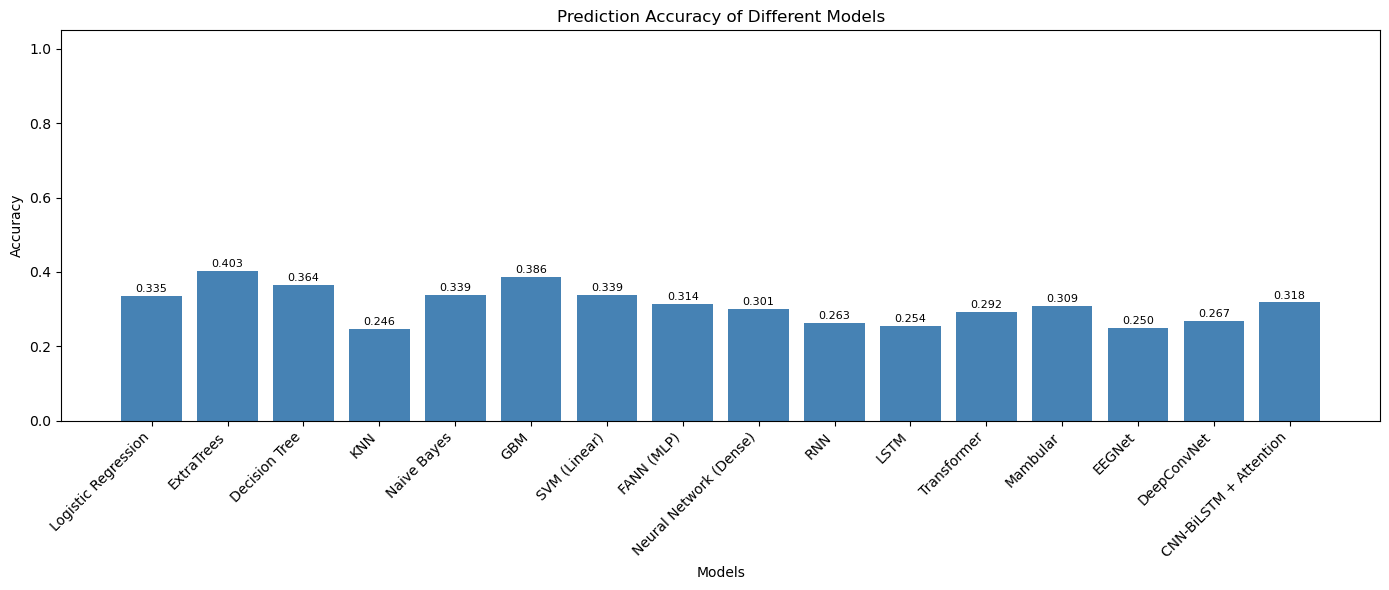

In [435]:
# Accuracy comparison across models (only include ones that exist)
model_acc = {}
for name, var in [
    ('Logistic Regression', 'log_acc'),
    ('ExtraTrees', 'et_acc'),
    ('Decision Tree', 'dt_acc'),
    ('KNN', 'knn_acc'),
    ('Naive Bayes', 'nb_acc'),
    ('GBM', 'gbm_acc'),
    ('SVM (Linear)', 'svm_acc'),
    ('FANN (MLP)', 'fann_acc'),
    ('Neural Network (Dense)', 'nn_acc'),
    ('RNN', 'rnn_acc'),
    ('LSTM', 'lstm_acc'),
    ('Transformer', 'transformer_acc'),
    ('Mambular', 'mambular_acc'),
    ('EEGNet', 'eegnet_acc'),
    ('DeepConvNet', 'deepconvnet_acc'),
    ('CNN-BiLSTM + Attention', 'cnn_bilstm_attn_acc'),
 ]:
    if var in globals():
        model_acc[name] = float(globals()[var])

plt.figure(figsize=(14, 6))
names = list(model_acc.keys())
scores = list(model_acc.values())
bars = plt.bar(names, scores, color='steelblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Prediction Accuracy of Different Models')

for b, s in zip(bars, scores):
    plt.text(b.get_x() + b.get_width()/2, s + 0.005, f'{s:.3f}', ha='center', va='bottom', fontsize=8)

plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

In [436]:
# Interpretation / Evaluation (robust to stale variables)
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

y_test_arr = np.asarray(y_test)
labels = sorted(pd.Series(y_test_arr).unique())
target_names = [str(l) for l in labels]

def _report(name: str, y_pred):
    if y_pred is None:
        print(f"{name}: not available")
        return
    y_pred = np.asarray(y_pred)
    if len(y_pred) != len(y_test_arr):
        print(f"{name}: skipped (length mismatch y_test={len(y_test_arr)} vs y_pred={len(y_pred)})")
        return
    print(f"{name}:")
    print(classification_report(y_test_arr, y_pred, target_names=target_names, zero_division=0))
    print('------------------------------------------------------\n')

# Logistic Regression
_report('Logistic Regression', globals().get('y_prediction'))

# ExtraTrees
_report('ExtraTrees', globals().get('y_pred_et'))

# Dense NN (recompute predictions if needed)
dense_pred = None
if 'nn_pred' in globals() and len(np.asarray(nn_pred)) == len(y_test_arr):
    dense_pred = nn_pred
else:
    # Try to recompute using the latest Keras dense model if it exists
    if 'model' in globals() and hasattr(model, 'predict') and 'X_test_scaled' in globals():
        try:
            probs = model.predict(X_test_scaled, verbose=0)
            dense_pred = np.argmax(probs, axis=1)
        except Exception as e:
            print('Dense NN: could not recompute predictions:', e)
            dense_pred = None

_report('Neural Network (Dense)', dense_pred)

Logistic Regression:
              precision    recall  f1-score   support

           0       0.36      0.38      0.37        60
           1       0.31      0.30      0.31        60
           2       0.30      0.28      0.29        60
           3       0.37      0.38      0.37        56

    accuracy                           0.33       236
   macro avg       0.33      0.34      0.33       236
weighted avg       0.33      0.33      0.33       236

------------------------------------------------------

ExtraTrees:
              precision    recall  f1-score   support

           0       0.44      0.33      0.38        60
           1       0.44      0.40      0.42        60
           2       0.34      0.35      0.35        60
           3       0.39      0.54      0.45        56

    accuracy                           0.40       236
   macro avg       0.41      0.40      0.40       236
weighted avg       0.41      0.40      0.40       236

-----------------------------------------